# Add a trend to a process

In this basic example we are going to add a trend to a process.

In [31]:
from __future__ import print_function
import openturns as ot
import math as m

In [32]:
# Create a process
myGrid = ot.RegularGrid(0.0, 0.1, 10)
amplitude=[5.0]
scale=[0.2]
myCovModel=ot.ExponentialModel(scale, amplitude)
process = ot.GaussianProcess(myCovModel, myGrid)

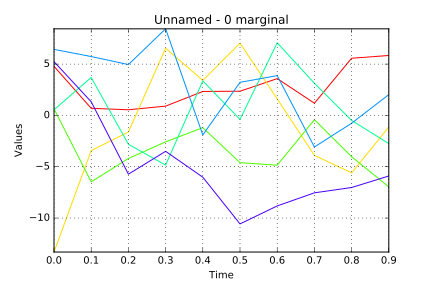

In [33]:
# Draw a sample
sample = process.getSample(6)
sample.drawMarginal(0)

In [34]:
# Define a trend function
f = ot.SymbolicFunction(['t'], ['30*t'])
fTrend = ot.TrendTransform(f)

In [35]:
# Add it to the process
transformed_process = ot.CompositeProcess(fTrend, process)

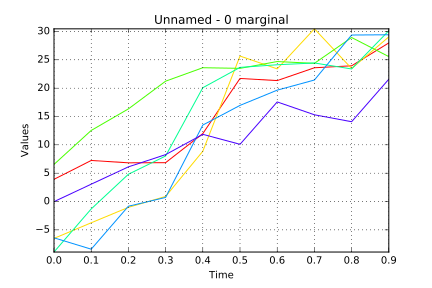

In [36]:
# Draw a sample
sample = transformed_process.getSample(6)
sample.drawMarginal(0)